In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from cooltools.lib.numutils import set_diag
from Bio import SeqIO

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from models import advanced_2d_cnn

import pandas

pandas.set_option('display.max_columns', 500)
pandas.set_option('display.max_rows', 500)

import h5py
import random

import math
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cooler
import cooltools as ct

import pickle

import scipy
import os
import re

In [18]:
# should be version 1.x
print(tf.__version__)

1.15.2


In [19]:
# the following directive activates inline plotting
%matplotlib inline

# allow to allocate resources for model training
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

In [20]:
from tensorflow.keras.backend import set_session
sess = tf.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [21]:
# UTIL FUNCTIONS

def plot_hic(matrix, use_log_scale = False, chromosome_position = ()):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    if use_log_scale:
        im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
        fig.colorbar(im)
    else:
        im = ax.matshow(matrix, cmap='YlOrRd')
        fig.colorbar(im)
    
    if len(chromosome_position) != 0:
        ax.set_title(f"{chromosome_position[0]}: {chromosome_position[1][0]}-{chromosome_position[1][1]}", fontsize=25)

        
def from_upper_triu(vector_repr, matrix_len = 512, num_diags = 2):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr[0, :, 0]
    
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
        
    return z + z.T


def one_hot_dna(sequence):
    seq_array = np.array(list(sequence))

    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)

    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)

    onehot_encoder = OneHotEncoder(sparse = False)
    result = onehot_encoder.fit_transform(integer_encoded_seq)

    # if Ns are present in the DNA sequence, result will have 5 columns. We delete 4th column which has Ns
    # N row in the resulting training set will have all 0s
    if result.shape[1] == 5:
        result = np.delete(result, 3, 1)

    return result


# combine all the transformations in one function
def transform_hic(hic_matrix, hic_matrix_raw):
    transformed_arr = ct.lib.numutils.adaptive_coarsegrain(hic_matrix, hic_matrix_raw)
    transformed_arr, _, _, _ = ct.lib.numutils.observed_over_expected(transformed_arr, mask = ~np.isnan(transformed_arr))
    transformed_arr = np.log(transformed_arr)
    transformed_arr = ct.lib.numutils.interp_nan(transformed_arr)
    transformed_arr = scipy.ndimage.gaussian_filter(transformed_arr, sigma = 1)
    
    return transformed_arr


def to_upper_triu(input_matrix, diagonal_offset = 2):
    seq_len = input_matrix.shape[0]
    return input_matrix[np.triu_indices(seq_len, diagonal_offset)].reshape([-1, 1])

In [22]:
######################### 
# Advanced 2D CNN Model
#########################

advanced_model = advanced_2d_cnn.Model().get_model()

# Load best weights from augmented training
advanced_model.load_weights("./weights/v2/model_80_epochs.h5")

In [23]:
# Read DNA sequence from a fasta file
# Sequence should be 526.000 nucleotides long

# FASTA_FILENAME = 'dna_seq_example'
# dna_seq = str(list(SeqIO.parse(open(f"./{FASTA_FILENAME}.fa"),'fasta'))[0].seq).upper()
offset = 128
fasta_sequence = list(SeqIO.parse(open(f"./chromFa/chr4.fa"),'fasta'))[0]
dna_seq = str(fasta_sequence.seq)[offset * 1000: offset * 1000 + 526000].upper()

print(len(dna_seq))

# one hot encode
dna_seq_one_hot = one_hot_dna(dna_seq)

# crop and prepare dna for the model
dna_seq_one_hot = dna_seq_one_hot[856:(526000 - 856), :].reshape(1, 524288, 4)

dna_seq_one_hot.shape

526000


(1, 524288, 4)

In [24]:
# Predict
prediction = advanced_model.predict(dna_seq_one_hot)

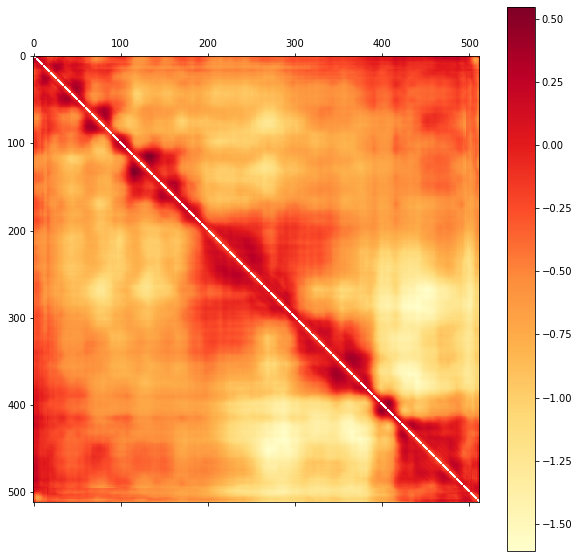

In [25]:
# Plot Hi-C
plot_hic(from_upper_triu(prediction))

In [26]:
# Original Hi-C

/opt/anaconda3/lib/python3.7/site-packages/cooltools/lib/numutils.py:1340: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


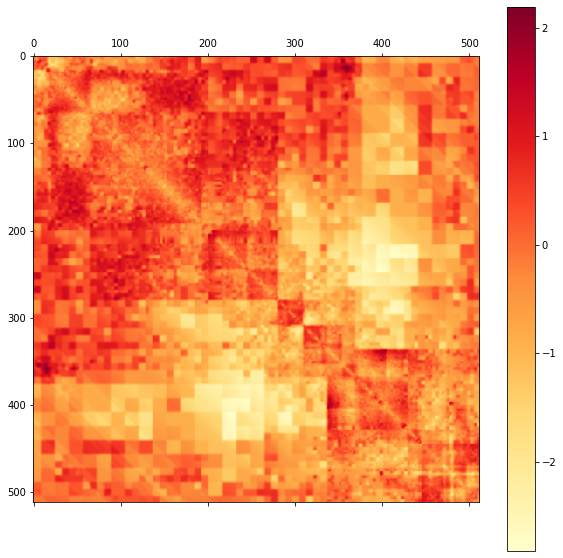

In [27]:
filepath = "S2-Wang2017-async.dm3.mapq_30.100.mcool"

resolution = "::/resolutions/1000" # 1 KB resolution
c = cooler.Cooler(filepath + resolution)

chrom = 'chr4'

arr = c.matrix(balance=True).fetch(chrom)[offset: offset + 526, offset: offset + 526]
# For adaptive coarse-grain transformation purposes
arr_raw = c.matrix(balance=False).fetch(chrom)[offset: offset + 526, offset: offset + 526]

transformed_arr = transform_hic(arr, arr_raw)[7:526 - 7, 7:526 - 7]

plot_hic(transformed_arr)

In [28]:
y_orig = to_upper_triu(transformed_arr)
y_pred = prediction

In [44]:
y_pred[0:100, ].flatten()

array([ 0.08446565,  0.18397424,  0.1741015 ,  0.17355081,  0.15373698,
        0.09341428,  0.06359285, -0.13536283, -0.19231169, -0.23338756,
       -0.22238515, -0.25098678, -0.27908403, -0.30051833, -0.36656085,
       -0.40740985, -0.41260937, -0.41089162, -0.4160322 , -0.4204431 ,
       -0.4099873 , -0.37913907, -0.3404194 , -0.42836067, -0.4072444 ,
       -0.3904164 , -0.3573689 , -0.32378078, -0.28668022, -0.2844812 ,
       -0.330468  , -0.27292496, -0.31549054, -0.2706151 , -0.2857389 ,
       -0.31105283, -0.3183404 , -0.32225454, -0.32059473, -0.274437  ,
       -0.31776813, -0.29067576, -0.27924812, -0.26798332, -0.26193255,
       -0.25259954, -0.24399132, -0.23548746, -0.25290358, -0.22439297,
       -0.24358329, -0.25534374, -0.26523903, -0.27478158, -0.2869956 ,
       -0.30059186, -0.30964306, -0.32050425, -0.32680607, -0.33692476,
       -0.3479569 , -0.37365642, -0.3917375 , -0.41410774, -0.42834207,
       -0.4467709 , -0.46351096, -0.46932268, -0.48094997, -0.48

In [42]:
y_orig.shape

(130305, 1)

In [69]:
from sklearn.metrics import r2_score

r2_score(y_orig.flatten(), y_pred.flatten())

-0.23836505589241974

In [59]:
a = np.random.rand(4000)
b = y_orig[0:70000, :]

In [60]:
a.shape

(4000,)

In [63]:
b = b.reshape((70000,))

In [66]:
b.shape

(70000,)

In [67]:
r_squared(b, b)

1.0

In [84]:
orig1 = y_orig[0:10, ]
orig1

array([[-0.29888121],
       [-0.16875091],
       [-0.09789852],
       [-0.04533878],
       [ 0.11542453],
       [ 0.29721912],
       [ 0.32590194],
       [ 0.25028999],
       [ 0.27753158],
       [ 0.33627333]])

In [86]:
pred1 = y_pred[0:10, ]
pred1

array([[ 0.08446565],
       [ 0.18397424],
       [ 0.1741015 ],
       [ 0.17355081],
       [ 0.15373698],
       [ 0.09341428],
       [ 0.06359285],
       [-0.13536283],
       [-0.19231169],
       [-0.23338756]], dtype=float32)

In [88]:
orig2 = y_orig.flatten()[0:10]
orig2

array([-0.29888121, -0.16875091, -0.09789852, -0.04533878,  0.11542453,
        0.29721912,  0.32590194,  0.25028999,  0.27753158,  0.33627333])

In [87]:
pred2 = y_pred.flatten()[0:10]
pred2

array([ 0.08446565,  0.18397424,  0.1741015 ,  0.17355081,  0.15373698,
        0.09341428,  0.06359285, -0.13536283, -0.19231169, -0.23338756],
      dtype=float32)

In [89]:
r_squared(orig1, pred1)

0.7561417708541116

In [90]:
r_squared(orig2, pred2)

-1.4385822914588826

In [93]:
r2_score(orig2, pred2)

-1.4385822914588826

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_orig.reshape(130305)[0:10000], y_pred.reshape(130305)[0:10000])
r_value**2

In [37]:
# helper function for the r_squared function
def _squared_error(original, predicted):
    return np.sum((predicted - original) * (predicted - original))


def r_squared(original, predicted):
    y_mean_line = [np.mean(original) for y in original]
    
    squared_error_regr = _squared_error(original, predicted)
    squared_error_y_mean = _squared_error(original, y_mean_line)
    
    return 1 - (squared_error_regr / squared_error_y_mean)

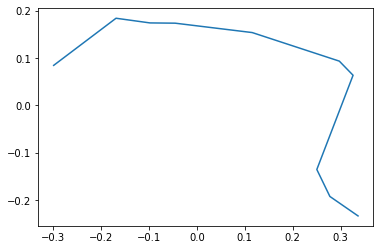

In [91]:
plt.plot(orig1, pred1)

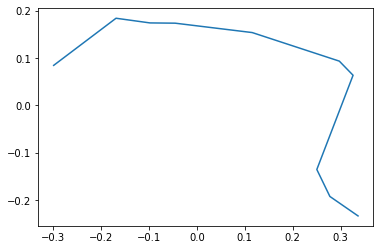

In [92]:
plt.plot(orig2, pred2)

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_orig, y_pred)
r_value**2

In [ ]:
correlation_matrix = np.corrcoef(y_orig, y_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

In [ ]:
y_orig.shape

In [ ]:
y_pred.shape

In [ ]:
offset = 0
avg_mse = 0
for i in range(700):
    print(i)
    offset = i
    CROPPING_TARGET = 7
    
    y_orig = to_upper_triu(transformed_arr[offset:offset+526, offset:offset+526][7:526 - CROPPING_TARGET, CROPPING_TARGET:526 - CROPPING_TARGET])
    seq_to_predict = one_hot_dna(fasta_seq[offset * 1000: offset*1000 + 526000])[856:(526000 - 856), :].reshape(1, 524288, 4)
    prediction = advanced_model.predict(seq_to_predict)
    y_pred = prediction.reshape(130305, 1).tolist()
    
    avg_mse += mean_squared_error(y_orig, y_pred)
    
avg_mse / 700

In [ ]:
from sklearn.metrics import mean_squared_error

y_orig = y_orig.tolist()
y_pred = prediction.reshape(130305, 1).tolist()

mean_squared_error(y_orig, y_pred)

In [ ]:
from sklearn.metrics import r2_score

avg_r = 0
for i in range(700):
    print(i)
    offset = i
    CROPPING_TARGET = 7
    
    y_orig = to_upper_triu(transformed_arr[offset:offset+526, offset:offset+526][7:526 - CROPPING_TARGET, CROPPING_TARGET:526 - CROPPING_TARGET])
    seq_to_predict = one_hot_dna(fasta_seq[offset * 1000: offset*1000 + 526000])[856:(526000 - 856), :].reshape(1, 524288, 4)
    prediction = advanced_model.predict(seq_to_predict)
    y_pred = prediction.reshape(130305, 1).tolist()
    
    avg_r += r2_score(y_orig, y_pred)
    
abs(avg_r/700)